<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a> ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>🌌Stellar</font>](https://www.kaggle.com/competitions/2oct23hse-stellar/rules)**. [**Instructions**](https://colab.research.google.com/drive/1riOGrE_Fv-yfIbM5V4pgJx4DWcd92cZr#scrollTo=ITaPDPIQEgXV) for running Colabs.

<small>**(Optional) CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes. We understand that sharing is optional and this decision will not affect our grade in any way. <font color=gray><i>(If ok with sharing your Colab for educational purposes, leave "X" in the check box.)</i></font></small>

In [ ]:
 from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 2oct23hse-stellar        # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
lb =!kaggle competitions leaderboard --show                   # print public leaderboard
lb

- competition is now set to: 2oct23hse-stellar


['Using competition: 2oct23hse-stellar',
 '  teamId  teamName             submissionDate       score    ',
 '--------  -------------------  -------------------  -------  ',
 '11016040  S                    2023-10-14 12:23:23  0.96930  ',
 '11041768  B                    2023-10-15 19:51:48  0.96910  ',
 '11016771  K                    2023-10-15 15:27:45  0.96835  ',
 '11013494  M                    2023-10-14 18:48:32  0.96810  ',
 '11053464  G                    2023-10-15 17:32:27  0.96705  ',
 '11047579  D                    2023-10-15 18:53:39  0.96705  ',
 '11028650  C, "Resting Kojima"  2023-10-15 13:19:18  0.96680  ',
 '11033947  N                    2023-10-15 11:27:44  0.96680  ',
 '11013404  R                    2023-10-15 11:50:25  0.96670  ',
 '11041778  Mikhail Gorodov      2023-10-15 17:19:47  0.96655  ',
 '11048424  L                    2023-10-15 19:51:08  0.96620  ',
 '11017247  Denis Kulakov        2023-10-10 14:10:47  0.96610  ',
 '11060229  Daria Lyakhova       20

In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression as LR
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA, LinearDiscriminantAnalysis as LDA
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)

CPU times: user 1.44 s, sys: 258 ms, total: 1.7 s
Wall time: 2.03 s


In [ ]:
df = pd.read_csv('XY_Stellar_4.csv'); df

,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,redshift,plate,MJD,fiber_ID,Class
0,11.64,21.28,26.28,26.15,24.05,18.87,19.00,8848,5,272,0.84,7740,56824,833,NaN
1,173.09,42.21,22.51,22.83,22.21,19.55,19.96,4156,3,486,0.81,9041,58067,428,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199998,131.31,44.27,24.07,24.64,21.63,19.20,19.03,7076,3,251,0.55,6014,56166,1021,G
199999,22.59,0.25,25.30,25.56,24.09,19.41,19.96,5164,4,511,1.26,9590,57969,878,G


In [ ]:
df.info()   # observe datatypes and any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 15 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   alpha     200000 non-null  float64
 1   delta     200000 non-null  float64
 2   u         200000 non-null  float64
 3   g         200000 non-null  float64
 4   r         200000 non-null  float64
 5   i         200000 non-null  float64
 6   z         200000 non-null  float64
 7   run_ID    200000 non-null  int64  
 8   cam_col   200000 non-null  int64  
 9   field_ID  200000 non-null  int64  
 10  redshift  200000 non-null  float64
 11  plate     200000 non-null  int64  
 12  MJD       200000 non-null  int64  
 13  fiber_ID  200000 non-null  int64  
 14  Class     160000 non-null  object 
dtypes: float64(8), int64(6), object(1)
memory usage: 22.9+ MB


In [ ]:
# Change string labels to numbers in order of increasing size of the entity (Star < Quasi Star < Galaxy)
df.Class = df.Class.apply(lambda C: -1 if C=='S' else 0 if C=='Q' else 1 if C=='G' else None)

In [ ]:
vX = df.query('Class!=Class').drop('Class', axis=1)  # slice a test sample
tXY = df.query('Class==Class')                       # slice training sample
tX, tY = tXY.drop('Class', axis=1), tXY.Class        # split into training I/O

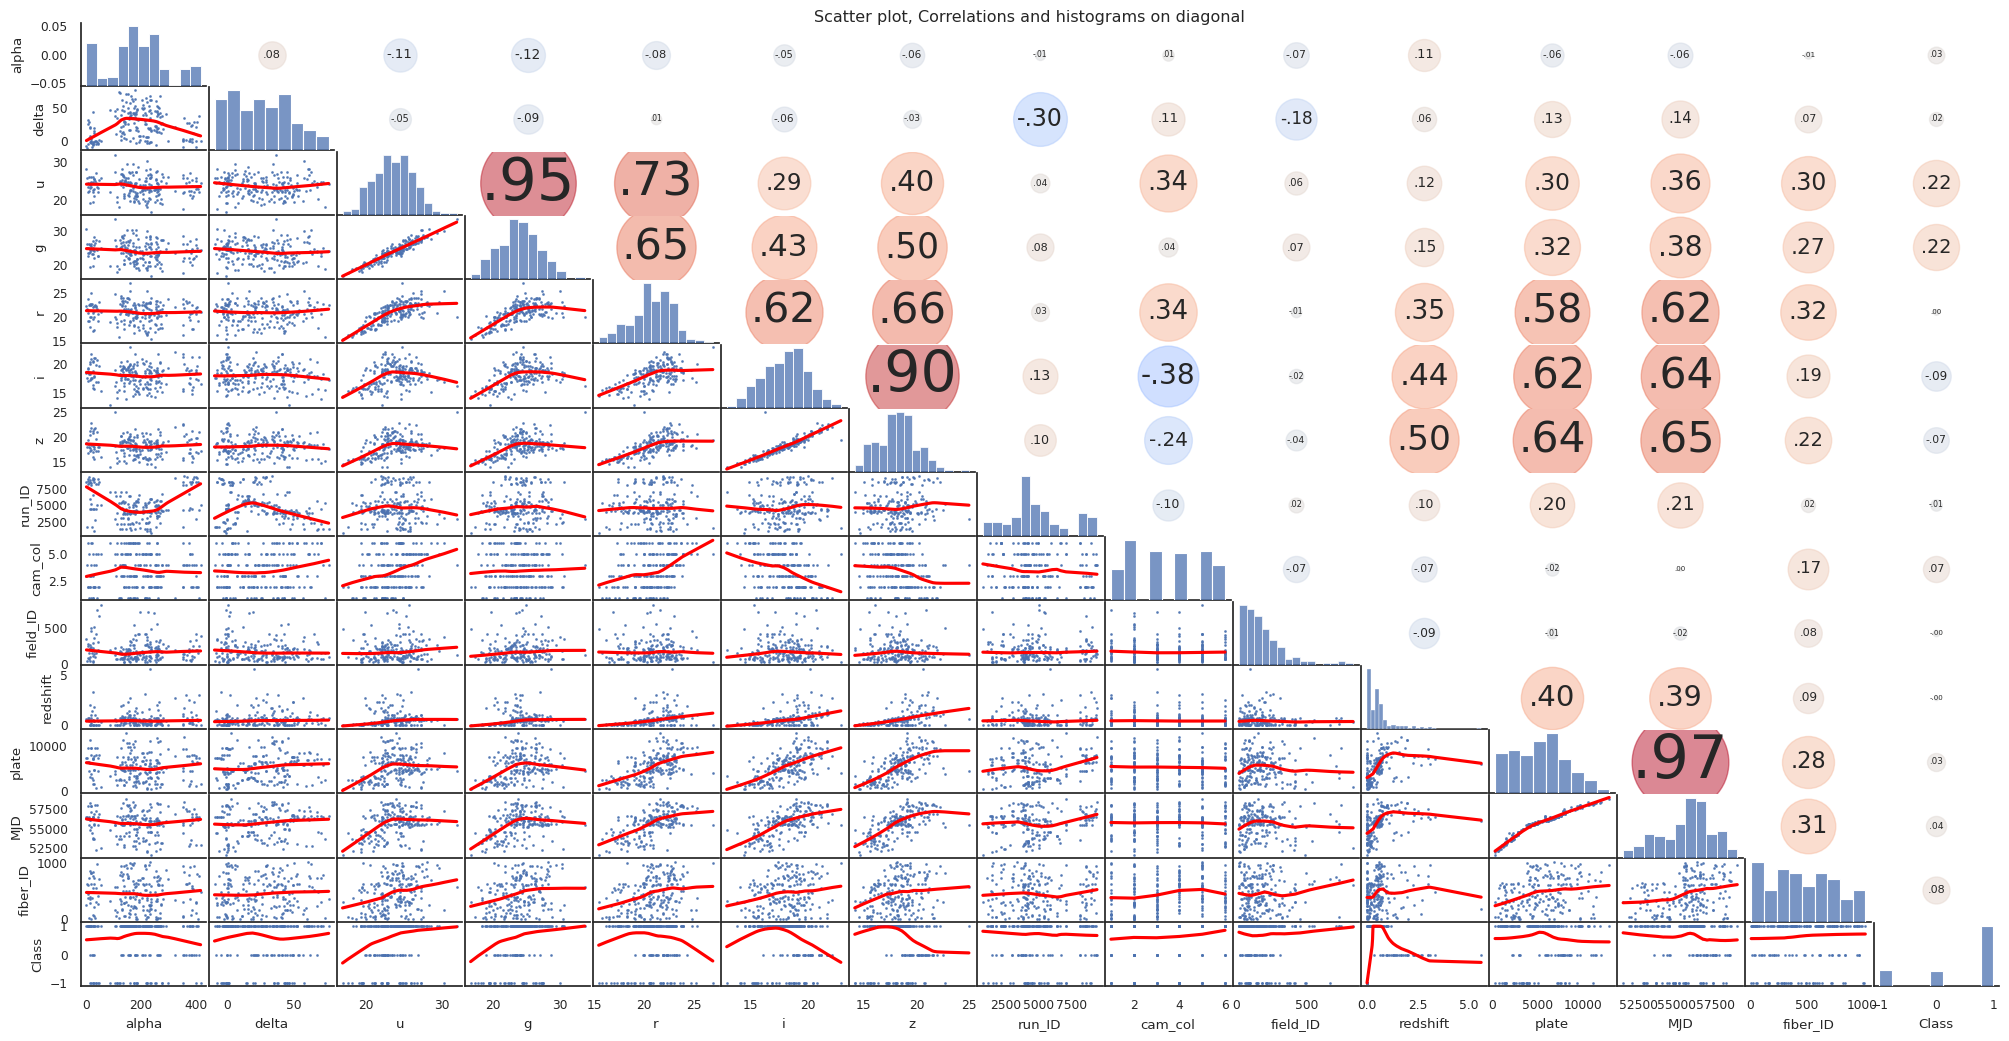

In [ ]:
def ScatterCorrHist(df):
  def corrdot(*args, **kwargs):
    # credit: https://stackoverflow.com/questions/48139899
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca();
    ax.set_axis_off();
    msz = abs(corr_r) * 5000   # marker size
    fsz = abs(corr_r) * 40 + 5 # font size
    ax.scatter([.5], [.5], msz, [corr_r], alpha=0.5, cmap='coolwarm', vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction", ha='center', va='center', fontsize=fsz)

  sns.set(style='white', font_scale=.8);
  g = sns.PairGrid(df, aspect=1, diag_sharey=False);
  g.fig.set_size_inches(20,10)
  g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color':'red'}, scatter_kws={'s':1});
  g.map_diag(sns.histplot, kde_kws={'color':'black'});
  g.map_upper(corrdot);
  g.fig.suptitle("Scatter plot, Correlations and histograms on diagonal", y=1);
  _ = plt.subplots_adjust(hspace=0.02, wspace=0.02);
  _ = plt.show();

ScatterCorrHist(tXY.head(200))

In [ ]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


<hr color=green size=40>

<strong><font color=green size=5>⏳Timed Green Playground (TGP): Your ideas, code, documentation, and timer START HERE!</font></strong>

<font color=green>Students: Keep all your definitions, code, documentation in <b>TGP</b>. Modifying any code outside of TGP incurs penalties.

<font color=green><h3><b>EDA</b><h3>

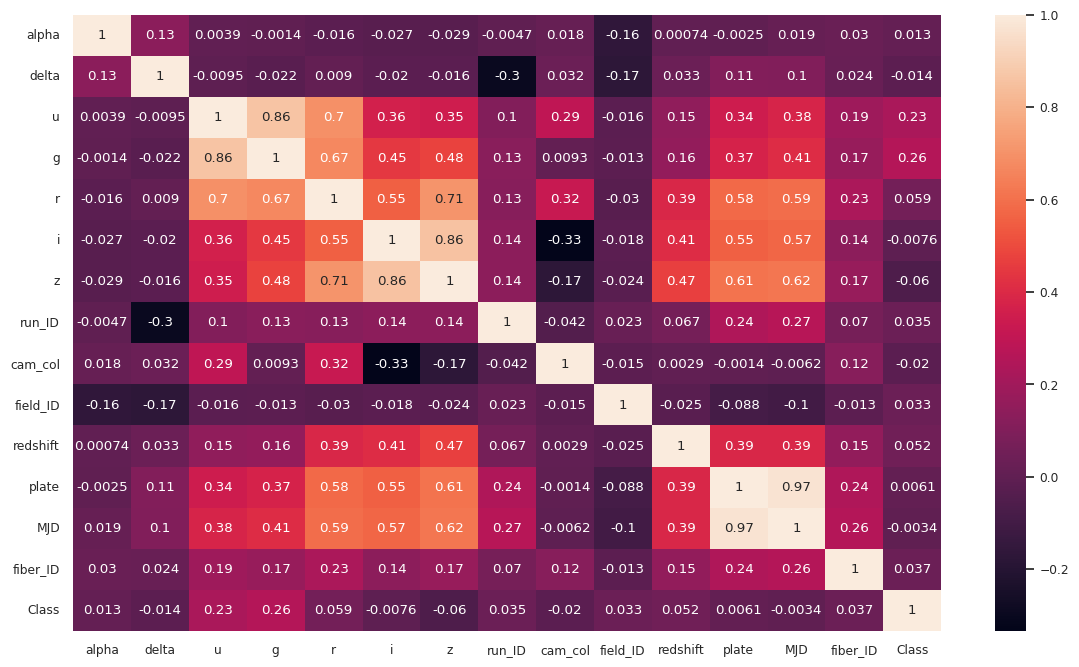

In [ ]:
import numpy as np, pandas as pd, matplotlib.pylab as plt
import seaborn as sns, statsmodels.api as sm
plt.figure(figsize=(14, 8));
ax = sns.heatmap(df.corr(numeric_only=True), annot=True);

<font color=green><h3><b>$0$. Data loading</b><h3>

In [ ]:
from sklearn.model_selection import train_test_split

df1 = pd.read_csv('XY_Stellar.csv');
col_to_select = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
      'redshift', 'MJD', 'Class']
df1 = df1[col_to_select]

# Change string labels to numbers in order of increasing size of the entity (Star < Quasi Star < Galaxy)
df1.Class = df1.Class.apply(lambda C: -1 if C=='S' else 0 if C=='Q' else 1 if C=='G' else None)

vX = df1.query('Class!=Class').drop('Class', axis=1)  # slice a test sample
tXY = df1.query('Class==Class')                       # slice training sample
tX, tY = tXY.drop('Class', axis=1), tXY.Class        # split into training I/O

# np.random.seed(0)
# X_train, Y_train = tX.iloc[:40000,:], tY[:40000]   # subsample for model selection experiments
# X_test, Y_test = tX.iloc[-120000:,:], tY[-120000:] # subsample for model selection experiments

X_train, X_test, Y_train, Y_test = train_test_split(
    tX, tY, test_size=0.65, random_state=42)

<font color=green><h3><b>$1$. Normalization of data</b><h3>


In [ ]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
mms.fit(X_train)

X_train_norm = pd.DataFrame(mms.transform(X_train), columns=X_train.columns)

X_test_norm = pd.DataFrame(mms.transform(X_test), columns=X_train.columns)

X_kaggle_norm = pd.DataFrame(mms.transform(vX), columns=X_train.columns)

MinMaxScaler()

<font color=green><h3><b>$2$. Build polynomial features</b><h3>

In [ ]:
%%time
poly = PolynomialFeatures(degree=4)    # add non-linear features (powers and interactions)
X_train_norm_poly = poly.fit_transform(X_train_norm.select_dtypes(include=np.number))  # create object on training set
X_test_norm_poly = poly.transform(X_test_norm.select_dtypes(include=np.number))      # apply the same object to test set
X_kaggle_norm_poly  = poly.transform(X_kaggle_norm.select_dtypes(include=np.number))       # apply the same object to test set

CPU times: user 1.32 s, sys: 625 ms, total: 1.94 s
Wall time: 2.09 s


<font color=green><h3><b>$3$. Fit a model</b><h3>

In [ ]:
m = QDA()
print(m.fit(X_train_norm_poly, Y_train).score(X_test_norm_poly, Y_test))   # fit the model and show test error

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.9639423076923077


Models perfomance comparison


1. 0.9511875 (without field_ID)
2. 0.950875 (without cam_col)
3. 0.950625 (all variables)
4. 0.9516458333333333 (without field_ID and cam_col)
5. 0.9523020833333333 (without all ID and cam_col)
6. 0.9524166666666667 (withot fiber_ID, field_ID, cam_col)
7. 0.9527083333333334 ((withot fiber_ID, field_ID, cam_col, plate)
8. 0.9591979166666667 deg = 3
9. 0.9638958333333333 deg = 4
10. 0.9639423076923077 deg = 4, test = 0.65
11. 0.9645 deg=4 test = 0.2

<font color=green><h3><b>$4$. Returning original data</b><h3>


In [ ]:
pY = pd.DataFrame(m.predict(X_kaggle_norm_poly), index=range(1,len(vX)+1), columns=['Class'])  # ensure that labels and observations are in corresponding order
df.Class.fillna('unknown').value_counts()   # distribution of all train labels
pY.value_counts()                           # distribution of predicted labels
pY.Class = pY.Class.apply(lambda C: 'S' if C==-1 else 'Q' if C==0 else 'G' if C==1 else None)
pY

1.0        95204
unknown    40000
-1.0       34362
0.0        30434
Name: Class, dtype: int64

Class
 1.0     23695
-1.0      8831
 0.0      7474
dtype: int64

,Class
1,G
2,G
...,...
39999,G
40000,S


In [ ]:
ToCSV(pY, 'norm_pol_3_QDA')

<font color=green><h3><b>$\epsilon$. Documentation</b></h3></font>

<font color=green><h4><b>Task 1. Explain Decisions in Preprocessing Pipeline</b></h4></font>

<font color=green>
Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.</font>

<font color=green>

1. Why did you choose these elements? (Something in EDA, prior experience,...? Note: EDA is not required)
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

1) Firstly, we worked with ordinal target variable, and turned them into numbers in order of increasing size of the entity (Star < Quasi Star < Galaxy). Also this helped us to find correlations.
Secondly, we made EDA for the dataset and found variables like ID, which certainly wouldn't affect the targert variable. So we perfomed feature selection, firstly by PCA library, but this approach decreased accuracy. So we started manually deleting features, and found the optimal ones. What is more interesting, deleting of red_shift variable with 0 correlation coeffiecent decreased accuracy by 0.3.Also, deleting run_ID also decreased accuracy.

2) We evaluated effectivenes of these methods on the test part, you can see results of these expeiments in the Models perfomance comparison

3) We also tried deleting of red_shift variable with 0 correlation coeffiecent ,but accuracy decreased by 0.3. Also, deleting run_ID  decreased accuracy.

<font color=green><h4><b>Task 2. Explain Decisions in Modeling Pipeline</b></h4></font>

<font color=green>
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful.

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

1) Firstly, we splitted and shuffled dataset into training and test parts
In the rules it is written that we should use definite stack of models, all of them were sensitive for scale of data. Our data was of different scale, so normalization was crucial. That's why perfomed this method
After that we applied Polynomization for the data, to work with more comples dependecies. We increased its power to the 4 power, what gave better accuracy than 3rd and 5th power.
Finally, we tried LR, LDA and QDA. These models, except for LR, don't need any hyperparametres tuning. The best perfomance had the QDA model

2) We evaluate the efficience by finding the best accuracy. We manually checked different models, splittings and etc. So the best combination is 20% of test part, 4th degree of PolynomialFeaturesa and QDA

3) We tried to use ansambling methods, especially bagging and voting between several models, but then we spotted, that it is prohibitted this method in the rules section
Also we tried LR and LDA. But they have worse accuracy than qda.

<font color=green><h3><b>$\zeta$. References</b></h3></font>

1. https://habr.com/ru/articles/550978/
1. https://scikit-learn.org/0.15/modules/generated/sklearn.qda.QDA.html
3. http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
4. http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

<font color=green>
Cite your sources to help your peers learn from these (and to avoid plagiarism claims). At the least, HOML textbook should be cited. Use Google Scholar to draw APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources.



<font size=5>⌛</font> <strong><font color=green size=5>Do not exceed competition's runtime limit! Do not write code outside TGP</font></strong>
<hr color=green size=40>

In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 11 sec


## 💡**Starter Ideas**

1. Tune model hyperparameters
1. Try to linear and non-linear feature normalization: shift/scale, log, divide features by features (investigate scatterplot matrix)
1. Try higher order feature interactions and polynomial features on a small subsample. Then identify key features or select key principal components. The final model can be trained on a larger or even full training sample. You can use [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the feature set
1. Do a thorough EDA: look for feature augmentations that result in linear decision boundaries between pairs of classes.
1. Evaluate predictions and focus on poorly predicted "groups":
  1. Strongest missclassifications. E.g. the model is very confident about the wrong label
  1. Evaluate predictions near decision boundaries.
1. Do scatter plots show piecewise linear shape? Can a separate linear model be used on each support, or can the pattern be linearized via transformations?
1. How are date/categorical features treated by the model? Is there a [better way](https://www.google.com/search?q=ways+to+encode+categorical+data) to encode these (perhaps, ordinal) features?
  1. E.g. you could replace codes (or groups of codes) with their frequencies, which may capture the implied "distance" or rarity between category levels.
  1. If encoding ordinal features with integers, should non-equidistant values be considered?
1. Learn astronomy domain and features: [🎦](https://www.youtube.com/results?search_query=Quasi-star), [quasi-star](https://en.wikipedia.org/wiki/Quasi-star), [star](https://en.wikipedia.org/wiki/Star), [galaxy](https://en.wikipedia.org/wiki/Galaxy), [📃](https://arxiv.org/abs/2112.02026)
